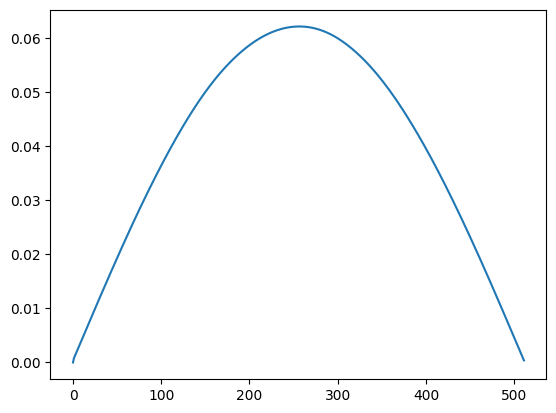

In [1]:
import os
os.chdir(r'/content/drive/MyDrive/Work/PI_deepOnet_General/Anti_derivative')
import torch
import torch.autograd as autograd
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import time
import scipy.io
import math
import scipy
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
import matplotlib.pyplot as plt
import operator
from functools import reduce
from functools import partial
from timeit import default_timer
import os
import csv
#from models import Green_transformer

class SimpleCSVLogger:
    def __init__(self, filepath):
        self.filepath = filepath

        # If the file doesn't exist, create one with headers.
        if not os.path.exists(filepath):
            with open(filepath, 'w', newline='') as csvfile:
                csvwriter = csv.writer(csvfile)
                csvwriter.writerow(['epoch', 'metric', 'value'])

    def log(self, epoch, metric, value):
        with open(self.filepath, 'a', newline='') as csvfile:
            csvwriter = csv.writer(csvfile)
            csvwriter.writerow([epoch, metric, value])

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#from utilities3 import *
Data = scipy.io.loadmat('Data.mat')
Fs = torch.tensor(Data['v'], dtype = torch.float32).to(device)
# COOR = torch.tensor(Data['coors'], dtype = torch.float32)
COOR = torch.linspace(0,1,Fs.size(1))[None,:,None].to(device)
coor  = COOR.repeat(len(Fs),1,1)
Y = torch.tensor(Data['u'], dtype = torch.float32).to(device)

Length = len(Fs)
Fs = Fs[:,:,None]
Y = Y[:,:,None]

Yc = Y.squeeze()
Yc_mean = torch.mean(Yc,axis=0)
Yc = Yc - Yc_mean
n = len(Yc)
C = 1 / (n - 1) * Yc.T @ Yc
w, v = torch.linalg.eigh(C)
v = torch.fliplr(v)
v *= len(Yc_mean) ** 0.5
Bases = v[None,:,:]
Bases = Bases/torch.max(Bases)

plt.figure()
plt.plot(Bases[:,:,0].detach().cpu().squeeze())

torch.manual_seed(0)
np.random.seed(0)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: Error: credential propagation was unsuccessful

In [2]:
batch_size = 16

x_data = Fs
c_data = coor
y_data = Y

x_train = x_data[0:int(0.8*Length),:,:]
c_train = c_data[0:int(0.8*Length),:,:]
y_train = y_data[0:int(0.8*Length),:,:]

x_test = x_data[int(0.8*Length):Length,:,:]
c_test = c_data[int(0.8*Length):Length,:,:]
y_test = y_data[int(0.8*Length):Length,:,:]

train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_train, c_train, y_train), batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_test, c_test, y_test), batch_size=batch_size, shuffle=False)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


In [3]:
class MLP1(nn.Module):
    def __init__(self,width_trunk, width_branch, length):
        super().__init__()
        layers = np.array([length,width_branch,width_branch,width_branch,width_branch,width_trunk])
        self.linears = torch.nn.Sequential(nn.Linear(layers[0],layers[1]), torch.nn.ReLU(),
                        nn.Linear(layers[1],layers[2]), torch.nn.ReLU(),
                        nn.Linear(layers[2],layers[3]), torch.nn.ReLU(),
                        nn.Linear(layers[3],layers[4]), torch.nn.ReLU(),
                        nn.Linear(layers[4],layers[5]))

    def forward(self,x):
        y = self.linears(x)
        return y

class MLP2(nn.Module):
    def __init__(self,width_trunk, width_branch, length):
        super().__init__()
        layers = np.array([length,width_branch,width_branch,width_branch,width_branch,width_trunk])
        self.linears = torch.nn.Sequential(nn.Linear(layers[0],layers[1]), torch.nn.ReLU(),
                          nn.Linear(layers[1],layers[2]), torch.nn.ReLU(),
                          nn.Linear(layers[2],layers[3]), torch.nn.ReLU(),
                          nn.Linear(layers[3],layers[4]), torch.nn.ReLU(),
                          nn.Linear(layers[4],layers[5]))

    def forward(self,x):
        y = self.linears(x)
        return y

class POD_DeepOnet(nn.Module):
    def __init__(self, width_trunk, width_branch, length, basis):
        super(POD_DeepOnet, self).__init__()

        self.encoder = nn.Linear(1, width_trunk) # input channel is 2: (a(x), x)
        self.B = basis[:,:,:width_trunk]
        self.w1 = torch.nn.Linear(width_trunk, width_trunk)
        self.w2 = torch.nn.Linear(width_trunk, width_trunk)
        self.w3 = torch.nn.Linear(width_trunk, width_trunk)
        self.w4 = torch.nn.Linear(width_trunk, width_trunk)
        self.MLP = MLP1(width_trunk, width_branch, length)

    def forward(self, x, c):
        x = x.repeat(1,1,c.size(1)).permute(0,2,1)
        # print(x.size())
        x1 = self.MLP(x)

        B = self.B.repeat(x.size(0),1,1)
        c = B*x1

        y = torch.sum(c,2)

        return y


In [4]:
model = POD_DeepOnet(width_trunk = 64, width_branch = 64, length = 512, basis = Bases).to(device, dtype = torch.float32)
print(count_parameters(model))
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)
num_epochs = 500

Rec = []

best_loss = np.inf
patience_counter=0
best_weights = None
patience = 300

for ep in range(num_epochs):
    model.train()
    t1 = default_timer()
    De_mse = 0
    train_l2 = 0
    ne = 0
    nt = 0
    for x, c, y in train_loader:
        ne += 1
        x, c, y = x.cuda(), c.cuda(), y.cuda()

        optimizer.zero_grad()
        c.requires_grad = True
        out = model(x,c)

        De = F.mse_loss(out.view(batch_size, -1), y.view(batch_size, -1))

        mse = De

        mse.backward() # use the l2 relative loss
        optimizer.step()

        De_mse += De.item()

    scheduler.step()
    model.eval()
    test_mse = 0.0
    with torch.no_grad():
        for x, c, y in test_loader:
            nt += 1
            x, c, y = x.cuda(), c.cuda(), y.cuda()

            out = model(x,c)
            test_mse += F.mse_loss(out.view(batch_size, -1), y.view(batch_size, -1)).item()

    De_mse /= ne
    test_mse /= nt

    t2 = default_timer()
    print(ep, t2-t1, De_mse, test_mse)
    recording = [t2-t1, De_mse, test_mse]
    Rec.append(recording)
#%%

66240
0 1.6942317270000018 0.02436934026516974 0.0017209580102935434
1 1.2488735200000036 0.0016259075510315598 0.0008526349812746048
2 1.2873876360000054 0.001045803611865267 0.0010819365670904518
3 1.291511442000001 0.000971727226919029 0.0007174292847048491
4 1.3243818960000056 0.001067275857727509 0.000729278553975746
5 1.2676868569999868 0.0007746761526213958 0.0007537477815058082
6 1.3017800840000007 0.0007844263865263201 0.002320586850866675
7 1.2583207220000077 0.0006867711144732311 0.0004230503698345274
8 1.272959954000001 0.0008577120881818701 0.00043389258137904106
9 1.2750455630000062 0.0004612994305207394 0.0009420748564880341
10 1.3245715309999895 0.0005884108030586503 0.0002301723597338423
11 1.3075054709999847 0.0010278338778880426 0.0002034965083003044
12 1.2819805690000123 0.0003345473973022308 0.0004244845067150891
13 1.3266858149999905 0.0004520672445942182 0.0021749389516189693
14 1.3173962350000181 0.0010950348940095864 0.0001721573625691235
15 1.271485757000022 0

In [5]:
mdic1 = {'Rec':Rec}
scipy.io.savemat(r'Recoding/Dp_PoD_training.mat',mdic1)

torch.save(model, 'Dp_PoD_model')

0.002408081000794482


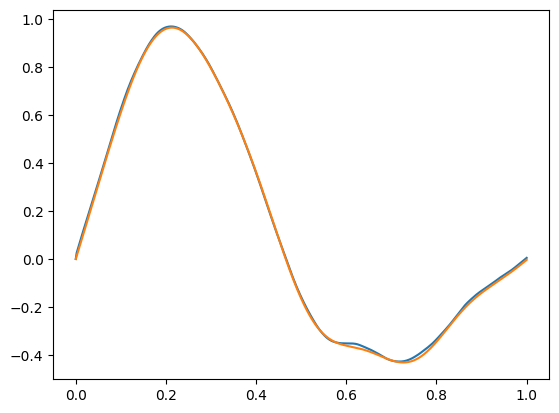

In [ ]:
num = 10 #10;20;60
x = x_test[num,:,:][None,:,:].cuda()
c = c_test[num,:,:][None,:,:].cuda()
y = y_test[num,:,:][None,:,:].cpu()
# x = torch.ones(1,n,1).cuda() + 10
t1 = default_timer()
out = model(x,c).squeeze().cpu()
t2 = default_timer()
print((t2-t1))

plt.figure()
plt.plot(c.squeeze().cpu().detach().numpy(),y.squeeze().detach().numpy())
plt.plot(c.squeeze().cpu().detach().numpy(),out.detach().numpy())
plt.show()


In [ ]:
xr = x.squeeze().cpu().detach().numpy()
cr = c.squeeze().cpu().detach().numpy()
yp = out.squeeze().cpu().detach().numpy()
yt = y.squeeze().cpu().detach().numpy()

mdic1 = {'x':xr,'c':cr,'yp':yp,'yt':yt}

# scipy.io.savemat(r'Recoding/Data1/Dp_relu.mat',mdic1)
# scipy.io.savemat(r'Recoding/Data1/pi_Dp_relu.mat',mdic1)
# scipy.io.savemat(r'Recoding/Data1/EDP_relu.mat',mdic1)
# scipy.io.savemat(r'Recoding/Data1/pi_EDP_relu.mat',mdic1)
scipy.io.savemat(r'Recoding/Data1/Dp_tanh.mat',mdic1)
# scipy.io.savemat(r'Recoding/Data1/pi_Dp_tanh.mat',mdic1)
# scipy.io.savemat(r'Recoding/Data1/EDP_tanh.mat',mdic1)
# scipy.io.savemat(r'Recoding/Data1/pi_EDP_tanh.mat',mdic1)

In [ ]:
xr = x.squeeze().cpu().detach().numpy()
cr = c.squeeze().cpu().detach().numpy()
yp = out.squeeze().cpu().detach().numpy()
yt = y.squeeze().cpu().detach().numpy()

mdic1 = {'x':xr,'c':cr,'yp':yp,'yt':yt}

# scipy.io.savemat(r'Recoding/Data2/Dp_relu.mat',mdic1)
# scipy.io.savemat(r'Recoding/Data2/pi_Dp_relu.mat',mdic1)
# scipy.io.savemat(r'Recoding/Data2/EDP_relu.mat',mdic1)
# scipy.io.savemat(r'Recoding/Data2/pi_EDP_relu.mat',mdic1)
scipy.io.savemat(r'Recoding/Data2/Dp_tanh.mat',mdic1)
# scipy.io.savemat(r'Recoding/Data2/pi_Dp_tanh.mat',mdic1)
# scipy.io.savemat(r'Recoding/Data2/EDP_tanh.mat',mdic1)
# scipy.io.savemat(r'Recoding/Data2/pi_EDP_tanh.mat',mdic1)

In [ ]:
xr = x.squeeze().cpu().detach().numpy()
cr = c.squeeze().cpu().detach().numpy()
yp = out.squeeze().cpu().detach().numpy()
yt = y.squeeze().cpu().detach().numpy()

mdic1 = {'x':xr,'c':cr,'yp':yp,'yt':yt}

# scipy.io.savemat(r'Recoding/Data3/Dp_relu.mat',mdic1)
# scipy.io.savemat(r'Recoding/Data3/pi_Dp_relu.mat',mdic1)
# scipy.io.savemat(r'Recoding/Data3/EDP_relu.mat',mdic1)
# scipy.io.savemat(r'Recoding/Data3/pi_EDP_relu.mat',mdic1)
scipy.io.savemat(r'Recoding/Data3/Dp_tanh.mat',mdic1)
# scipy.io.savemat(r'Recoding/Data3/pi_Dp_tanh.mat',mdic1)
# scipy.io.savemat(r'Recoding/Data3/EDP_tanh.mat',mdic1)
# scipy.io.savemat(r'Recoding/Data3/pi_EDP_tanh.mat',mdic1)

ValueError: ignored

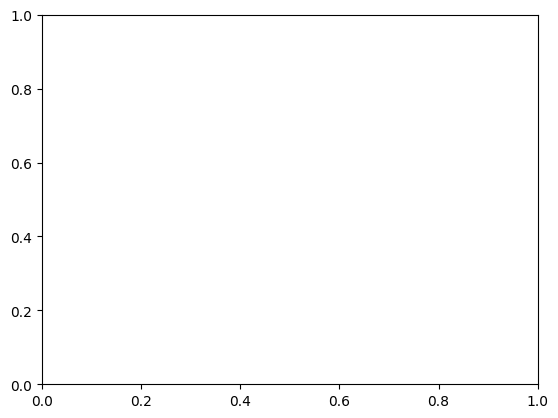

In [ ]:
n = 128

num = 2
x = x_test[num,:,:][None,:,:].cuda()
c = c_test[num,:,:][None,:,:].cuda()
y = y_test[num,:,:][None,:,:].cpu()
c.requires_grad = True
out = model(x,c)
dydc = autograd.grad(out,c,torch.ones_like(out).to(device),retain_graph=True,create_graph=True)[0]
# dydc2 = autograd.grad(dydx,c,torch.ones_like(dydx).to(device),retain_graph=True,create_graph=True)[0]

xl = torch.linspace(0,1,n)

out = out.squeeze()
dydc = dydc.squeeze()
dout = (out[1:] - out[:-1])*(n-1)


plt.figure()
plt.plot(xl.squeeze().cpu().detach().numpy(),out.squeeze().cpu().detach().numpy())
plt.show()
plt.figure()
plt.plot(xl.squeeze().cpu().detach().numpy(),dydc.squeeze().cpu().detach().numpy())
# plt.plot(xl.squeeze().cpu().detach().numpy(),x.squeeze().cpu().detach().numpy())
plt.plot(xl[1:].squeeze().cpu().detach().numpy(),dout.squeeze().cpu().detach().numpy())
# plt.plot(xl.squeeze().cpu().detach().numpy(),dydx2.squeeze().cpu().detach().numpy())
plt.show()